# 1. Objetivo

Utilizar el algoritmo de XGBoost para trabajar con Series Temporales. [XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

El dataset con el que vamos a trabajar en este notebook contiene un total de **426 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. 

Cada una de estas **Series Temporales** representan las ventas <u>**MENSUALES**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

# 2. Librerías


In [1]:
# Datos
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
import os

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Métricas de evaluacion
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modelos a Entrenar
import xgboost as xgb

# inhabilita warnings
import warnings
warnings.filterwarnings("ignore")

# 3. Load Data

In [2]:
df = pd.read_csv('C:/Users/aalei/Desktop/time_series/data/ts_kaggle_train.csv', index_col = 0)
print('Rows: ', df.shape[0], '  Columns: ', df.shape[1])
df.head(2)

Rows:  14484   Columns:  8


,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0


In [3]:
new_name = {'monthly_sales': 'sales', 'monthly_average_price': 'price', 'unique_id':'id','city_id':'region','shop_id':'store','item_category_id':'category','item_id':'item'}
df = df.rename(columns=new_name)

# 4. Exploratory Data Analysis EDA

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      14484 non-null  datetime64[ns]
 1   id        14484 non-null  object        
 2   region    14484 non-null  int64         
 3   store     14484 non-null  int64         
 4   category  14484 non-null  int64         
 5   item      14484 non-null  int64         
 6   price     13262 non-null  float64       
 7   sales     13756 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,14484,2014-06-15 11:17:38.823529472,2013-01-31 00:00:00,2013-09-30 00:00:00,2014-06-15 00:00:00,2015-02-28 00:00:00,2015-10-31 00:00:00,NaN
region,14484.0,10.833333,0.0,7.0,7.0,16.0,23.0,6.227364
store,14484.0,31.967136,3.0,22.0,31.0,44.0,59.0,15.236351
category,14484.0,39.356808,2.0,30.0,35.0,55.0,83.0,20.439654
item,14484.0,8626.431925,32.0,4248.0,6457.0,12551.0,22088.0,5905.273346
price,13262.0,916.089314,4.928571,299.0,649.0,1149.0,9305.121212,820.945949
sales,13756.0,7.337889,0.0,2.0,5.0,9.0,30.0,7.915032


In [7]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 10)
    plot_pacf(x = y, ax = ax3, lags = 10)

    plt.suptitle(t = title, fontsize = 20)

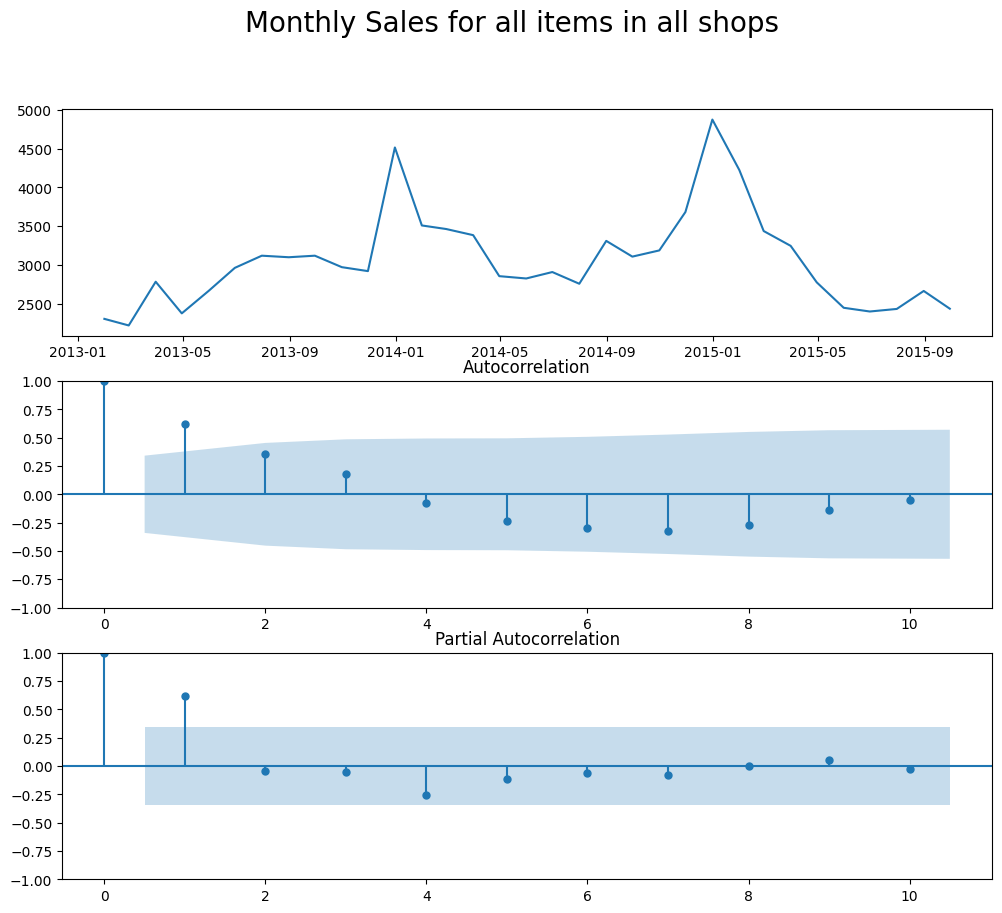

In [8]:
y = df.set_index("date").resample("M")["sales"].sum()[:-1] # quitamos los registros de octubre
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

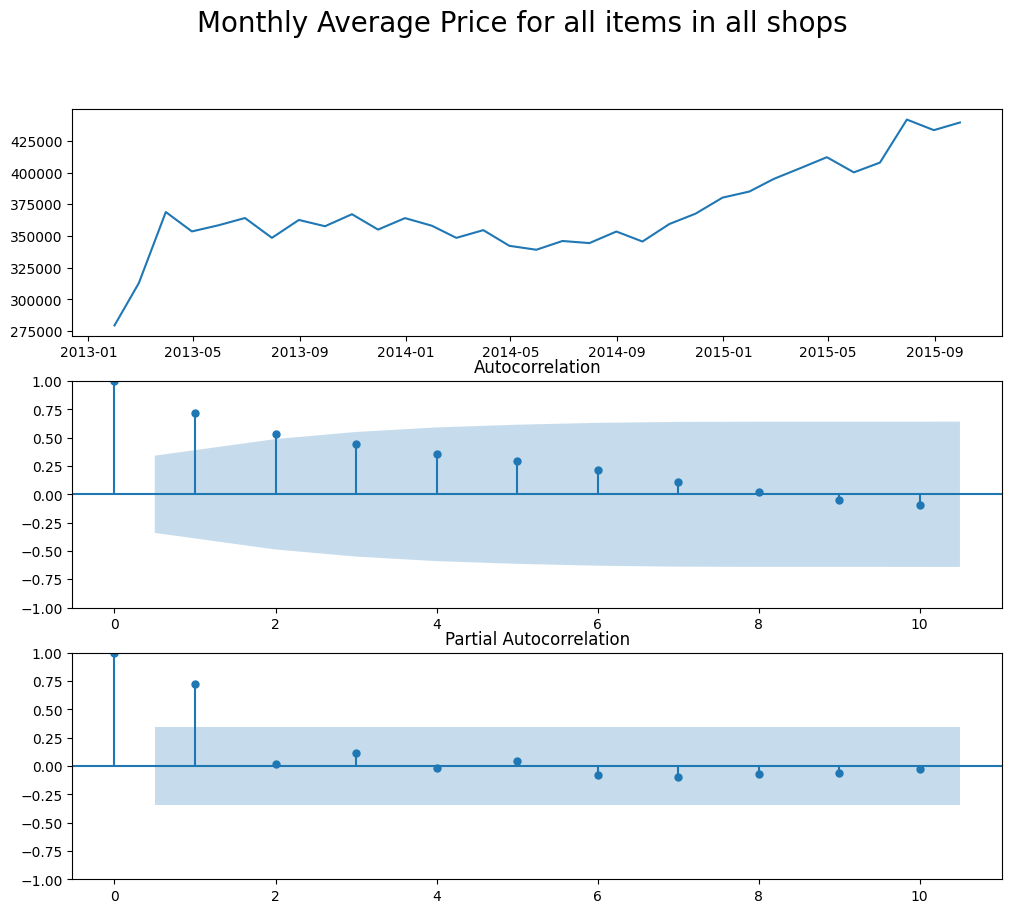

In [9]:
y = df.set_index("date").resample("M")["price"].sum()[:-1] # quitamos los registros de octubre
plot_ts_acf_pacf(y = y, title = "Monthly Average Price for all items in all shops");

In [10]:
print(f"There are {df["id"].nunique()} time series in this dataset") 

There are 426 time series in this dataset


* De 24 ciudades diferentes (city_id)
* De 35 tiendas diferentes (shop_id)
* De 28 categorías de item diferentes(item_category_id) 
* De 132 item diferentes (item_id).

Veamos cuales son las fechas min y max de nuestro dataset:

In [11]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


### Top 3 Cities

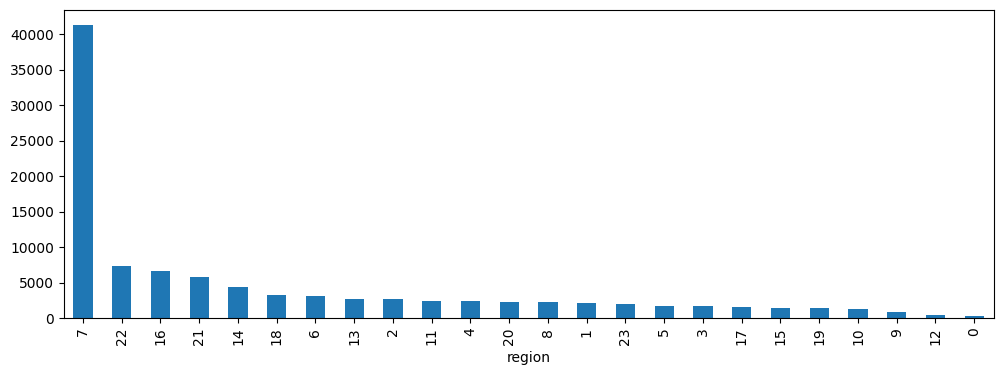

In [12]:
(
    df.
    groupby(["region"])
    ["sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### Top 3 Categories

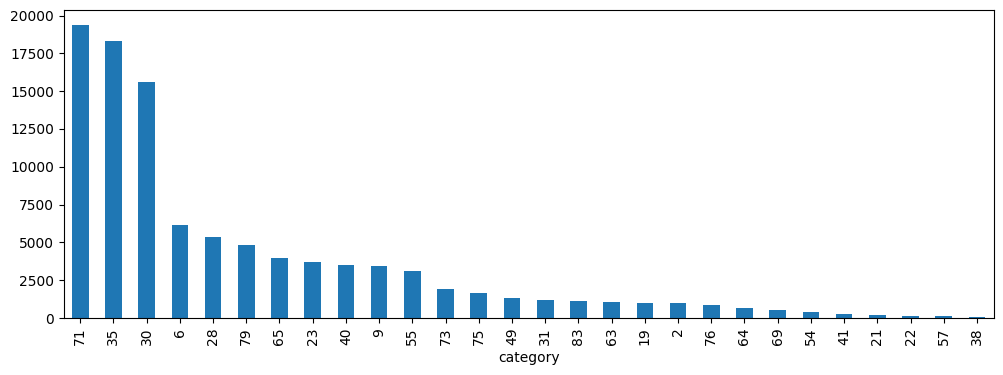

In [13]:
(
    df.
    groupby(["category"])
    ["sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

# 5. Outlayers

<Axes: ylabel='sales'>

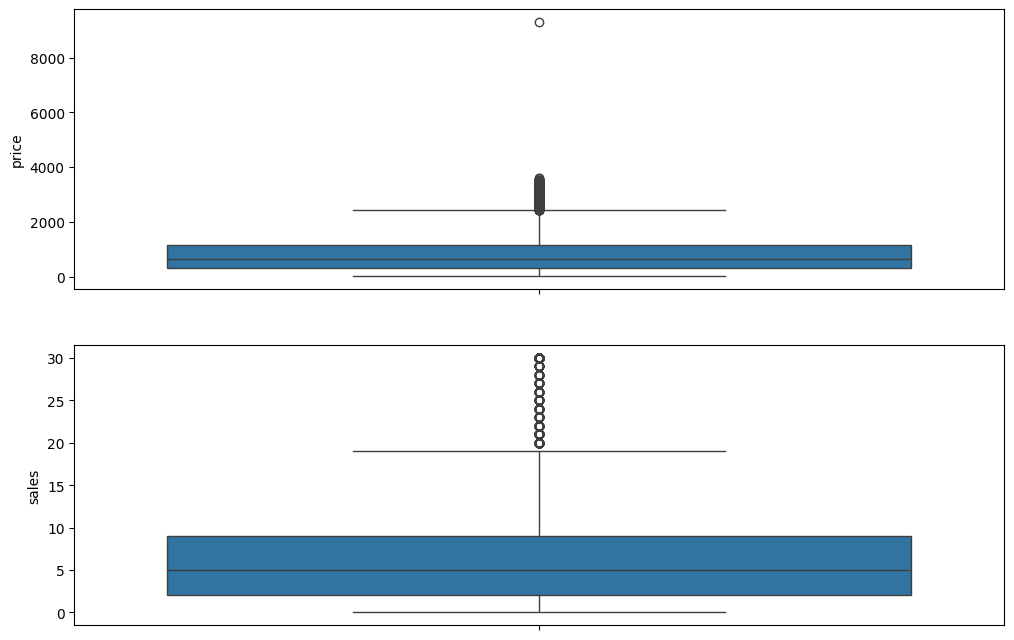

In [14]:
#Se analiza la distribucion del precio por item y el numero de items vendidos por dia mediante diagramas de box.
fig, ax = plt.subplots(2,1, figsize=(12,8))
sns.boxplot(df["price"], ax=ax[0])
sns.boxplot(df["sales"], ax=ax[1])

In [15]:
print(df['price'].max())
df[(df['id']=='12_11365')&(df['region']==16)]

9305.121212120908


,date,id,region,store,category,item,price,sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0
35,2013-06-30,12_11365,16,12,9,11365,1302.343750,28.0
42,2013-07-31,12_11365,16,12,9,11365,1736.785714,20.0
49,2013-08-31,12_11365,16,12,9,11365,3072.361111,16.0
56,2013-09-30,12_11365,16,12,9,11365,9305.121212,24.0
63,2013-10-31,12_11365,16,12,9,11365,2493.113360,30.0


In [16]:
#calcular la media con el valor anterior y posterior para el mismo id e imputar
(3072.361111 + 2493.113360)/2
df.loc[df['price'] >8000, 'price'] = 2782.7372

# 6. Data Imputation

In [17]:
df.isnull().sum()

date           0
id             0
region         0
store          0
category       0
item           0
price       1222
sales        728
dtype: int64

In [18]:
# Selecciona las filas donde las ventas y el precio es nulo:
df.loc[(df['sales'].isnull()) & (df['price'].isnull()), ['sales', 'price']] = 0
df.isnull().sum()

date          0
id            0
region        0
store         0
category      0
item          0
price       494
sales         0
dtype: int64

In [19]:
df["price"] = df.groupby(["id","region","store","category","id"], group_keys = False)["price"].apply(
    lambda series: series.backfill().ffill()
)
df.isnull().sum().sum()

0

In [20]:
df.sort_values(["id", "date"], ascending = True, inplace = True)

# 6. Build Features

In [21]:
df.head(2)

,date,id,region,store,category,item,price,sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0


In [22]:
# Variables temporales
#df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
#df['year'] = df['date'].dt.year
#df['cumulative_month'] = (df['date'].dt.year - 2013) * 12 + df['date'].dt.month
df.head(2)

,date,id,region,store,category,item,price,sales,day
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28


In [23]:
# Revenue y lag_1 de revenue
#df['revenue']= df['sales'] * df['price']
#df['id_revenue_mean_lag_1'] = df.groupby(["id"])["revenue"].transform(lambda series: series.shift(1))

# Sales lag_1 y diferencia de sales de 1 semana
#df['id_sales_sum_lag_1'] = df.groupby(["id"])["sales"].transform(lambda series: series.shift(1))
#df['id_sales_sum_lag_2'] = df.groupby(["id"])["sales"].transform(lambda series: series.shift(2))
#df['id_sales_sum_lag_3'] = df.groupby(["id"])["sales"].transform(lambda series: series.shift(3))
#df['dif_sales_1w'] = df['id_sales_sum_lag_1'] - df['sales']

# Sales lag_4 y diferencia de sales de 4 semanas
#df['id_sales_sum_lag_4'] = df.groupby(["id"])["sales"].transform(lambda series: series.shift(2))
#df['dif_sales_4w'] = df['id_sales_sum_lag_4'] - df['sales']

# Price lag_4 y diferencia de price de 4 semanas
#df['id_price_lag_4'] = df.groupby(["id"])["price"].transform(lambda series: series.shift(2))
#df['dif_price_4w'] = df['id_price_lag_4'] - df['price']

#df.head(2)

In [24]:
df1 = df[df['date'] < '2015-10-01']

In [25]:
# Función para crear lags de variables agrupadas
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name,resample_value):
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample(resample_value)[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
    gb_df_[f"{new_name}_lag_1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )
    gb_df_[f"{new_name}_lag_2"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(2)
    )
    gb_df_[f"{new_name}_lag_3"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(3)
    )
    gb_df_[f"{new_name}_lag_4"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(4)
    )
    #gb_df_[f"{new_name}_lag_12"] = gb_df_.groupby(gb_list)[new_name].transform(
    #    lambda series: series.shift(12)
    #)
    print(f"Plus 3 lags features for: {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [26]:
'''vars_ts_item_id = build_ts_vars(
 full_df = full_df,
 gb_list = ["DATE", "SHOP_ID", "ITEM_ID"],
 target_column = "MONTHLY_SALES",
 agg_func = np.sum,
 agg_func_name = "SUM"
)

2. Otra cosa que he visto muy a menudo: personas que generan variable autoexplicativas (agrupaban las ventas por item_category_id por ejemplo y no dropeaban el mes de entrenamiento). OJO con este tipo de cosas.
3. Otro fallo bastante común es olvidarse que estamos trabajando con 299 TS. Por este motivo, si quiero generar una media móvil. Tengo que hacer algo parecido a esto:
df["SALES_MA_3"] = df.groupby(["unique_id"])["SALES"].transform(lambda series: series.shift(1).rolling(3).mean())'''

'vars_ts_item_id = build_ts_vars(\n full_df = full_df,\n gb_list = ["DATE", "SHOP_ID", "ITEM_ID"],\n target_column = "MONTHLY_SALES",\n agg_func = np.sum,\n agg_func_name = "SUM"\n)\n\n2. Otra cosa que he visto muy a menudo: personas que generan variable autoexplicativas (agrupaban las ventas por item_category_id por ejemplo y no dropeaban el mes de entrenamiento). OJO con este tipo de cosas.\n3. Otro fallo bastante común es olvidarse que estamos trabajando con 299 TS. Por este motivo, si quiero generar una media móvil. Tengo que hacer algo parecido a esto:\ndf["SALES_MA_3"] = df.groupby(["unique_id"])["SALES"].transform(lambda series: series.shift(1).rolling(3).mean())'

In [27]:
df.head(2)

,date,id,region,store,category,item,price,sales,day
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28


In [28]:
# TARGET: SALES
print(f'Dimensión inicial df: {df.shape}')

# Add the previous month's average item_cnt
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["store","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")

'''# Add the previous month's average item_cnt
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["store","category","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","category","item"], how = "left")

# Add lag values of item_cnt_month for month / item_id.
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["cumulative_month","item"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name = "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["cumulative_month","item"], how = "left")

# Add lag values for item_cnt_month for every month / shop combination
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["cumulative_month","store"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name = "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["cumulative_month","store"], how = "left")

# Add lag values for item_cnt_month for month/shop/item
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["cumulative_month","store","item"],
    target_column = "sales",
    agg_func = np.mean,
    resample_value='M',
    agg_func_name = "mean")
df = pd.merge(df, vars_ts_, on = ["date"] + ["cumulative_month","store","item"], how = "left")

# Add lag values for item_cnt_month for month/shop/item subtype
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["cumulative_month","store","category","item"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name =  "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["cumulative_month","store","category","item"], how = "left")

# Add lag values for item_cnt_month for month/city
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["cumulative_month","region"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name =  "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["cumulative_month","region"], how = "left")

# Add lag values for item_cnt_month for month/city/item
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["cumulative_month","region","item"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name = "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["cumulative_month","region","item"], how = "left")

# Suma de ventas agrupadas por category, department e item
vars_ts_ = build_ts_vars(
    df = df,
    gb_list = ["category","region","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["category","region","item"], how = "left")

# Promedio de ventas agrupado por category, event, item y region
vars_ts_ = build_ts_vars(
    df = df,
    gb_list = ["category","item","region"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name =  "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["category","item","region"], how = "left")'''

print(f'Dimensión final df: {df.shape}')
df.head()

Dimensión inicial df: (14484, 9)
Plus 3 lags features for: store_item_sales_sum
Dimensión final df: (14484, 13)


,date,id,region,store,category,item,price,sales,day,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28,30.0,NaN,NaN,NaN
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,31,27.0,30.0,NaN,NaN
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,30,30.0,27.0,30.0,NaN
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,31,27.0,30.0,27.0,30.0


In [29]:
'''# TARGET: PRICE
print(f'Dimensión inicial df: {df.shape}')
# Promedio de revenue agrupado por store e item
vars_ts_ = build_ts_vars(
    df = df,
    gb_list = ["store","item"],
    target_column = "price",
    agg_func = np.mean,
    agg_func_name =  "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")

# Promedio de ventas agrupadas por item y evento
vars_ts_ = build_ts_vars(
    df = df,
    gb_list = ["id","item"],
    target_column = "price",
    agg_func = np.mean,
    agg_func_name = "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["id","item"], how = "left")
print(f'Dimensión final df: {df.shape}')
df.head()'''

'# TARGET: PRICE\nprint(f\'Dimensión inicial df: {df.shape}\')\n# Promedio de revenue agrupado por store e item\nvars_ts_ = build_ts_vars(\n    df = df,\n    gb_list = ["store","item"],\n    target_column = "price",\n    agg_func = np.mean,\n    agg_func_name =  "mean",\n    resample_value=\'M\')\ndf = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")\n\n# Promedio de ventas agrupadas por item y evento\nvars_ts_ = build_ts_vars(\n    df = df,\n    gb_list = ["id","item"],\n    target_column = "price",\n    agg_func = np.mean,\n    agg_func_name = "mean",\n    resample_value=\'M\')\ndf = pd.merge(df, vars_ts_, on = ["date"] + ["id","item"], how = "left")\nprint(f\'Dimensión final df: {df.shape}\')\ndf.head()'

In [30]:
# TARGET: REVENUE

# Borrar features que no serán parte del modelo

In [31]:
COLUMNS_TO_DROP = [] 
df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [32]:
print(df.columns)

Index(['date', 'id', 'region', 'store', 'category', 'item', 'price', 'sales',
       'day', 'store_item_sales_sum_lag_1', 'store_item_sales_sum_lag_2',
       'store_item_sales_sum_lag_3', 'store_item_sales_sum_lag_4'],
      dtype='object')


In [33]:
df.set_index("id", inplace = True)
df.sample(3)

,date,region,store,category,item,price,sales,day,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4
id,,,,,,,,,,,,
42_20949,2014-11-30,14,42,71,20949,5.0,30.0,30,30.0,30.0,30.0,30.0
24_3148,2015-10-31,7,24,75,3148,0.0,0.0,31,NaN,NaN,NaN,NaN
28_7213,2013-11-30,7,28,19,7213,899.0,3.0,30,1.0,1.0,3.0,10.0


# Train Test Split

In [34]:
train_index = sorted(list(df["date"].unique()))[:-2]

valida_index = [sorted(list(df["date"].unique()))[-2]]

test_index = [sorted(list(df["date"].unique()))[-1]]

print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-31 00:00:00')]

Our validation index is [Timestamp('2015-09-30 00:00:00')]

Our test/prediction index is [Timestamp('2015-10-31 00:00:00')]



In [35]:
X_train = df[df["date"].isin(train_index)].drop(['sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['sales']

X_valida = df[df["date"].isin(valida_index)].drop(['sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['sales']

X_test = df[df["date"].isin(test_index)].drop(['sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['sales']

In [36]:
print(f'Train shape: {X_train.shape}, Valida shape: {X_valida.shape}, Test shape: {X_test.shape}')

Train shape: (13632, 10), Valida shape: (426, 10), Test shape: (426, 10)


In [37]:
X_train.head(2)

,region,store,category,item,price,day,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4
id,,,,,,,,,,
12_11365,16,12,9,11365,1511.512626,31,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,1533.125000,28,30.0,NaN,NaN,NaN


In [38]:
X_test.head(2)

,region,store,category,item,price,day,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4
id,,,,,,,,,,
12_11365,16,12,9,11365,0.0,31,NaN,NaN,NaN,NaN
12_11369,16,12,9,11369,0.0,31,NaN,NaN,NaN,NaN


In [39]:
Y_test.sum()  # debe ser 0

0.0

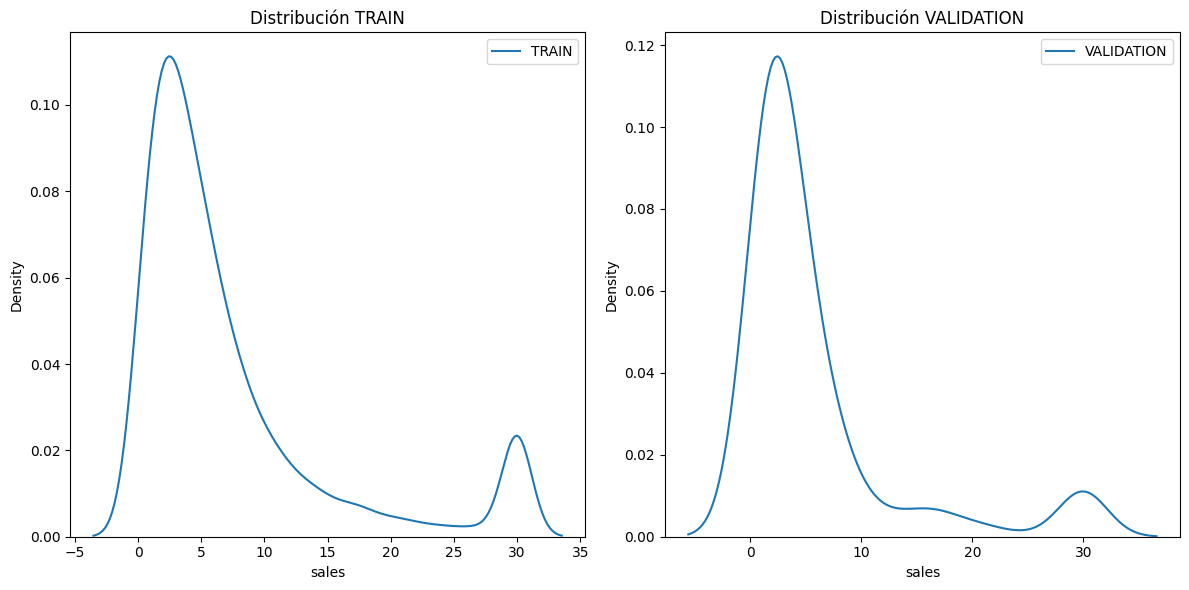

In [40]:
# Distribucion de target en train y validación
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.kdeplot(Y_train, ax=axes[0], label='TRAIN')
axes[0].set_title('Distribución TRAIN')
axes[0].legend()

sns.kdeplot(Y_valida, ax=axes[1], label='VALIDATION')
axes[1].set_title('Distribución VALIDATION')
axes[1].legend()

plt.tight_layout()
plt.show()


# Model Train

In [41]:
model = xgb.XGBRegressor(seed=175)

model.fit(
     X_train,
     Y_train,
     eval_metric = "rmse", 
     eval_set = [(X_train, Y_train), (X_valida, Y_valida)],  
     verbose = True,
     early_stopping_rounds = 15
     )

[0]	validation_0-rmse:6.29850	validation_1-rmse:5.83695
[1]	validation_0-rmse:5.30172	validation_1-rmse:4.71847
[2]	validation_0-rmse:4.70043	validation_1-rmse:4.01103
[3]	validation_0-rmse:4.35092	validation_1-rmse:3.56270
[4]	validation_0-rmse:4.12767	validation_1-rmse:3.29500
[5]	validation_0-rmse:4.00532	validation_1-rmse:3.14702
[6]	validation_0-rmse:3.91812	validation_1-rmse:3.07196
[7]	validation_0-rmse:3.85777	validation_1-rmse:2.99939
[8]	validation_0-rmse:3.80828	validation_1-rmse:2.98930
[9]	validation_0-rmse:3.74144	validation_1-rmse:2.99087
[10]	validation_0-rmse:3.67367	validation_1-rmse:2.97079
[11]	validation_0-rmse:3.62872	validation_1-rmse:2.98315
[12]	validation_0-rmse:3.58575	validation_1-rmse:3.00155
[13]	validation_0-rmse:3.55316	validation_1-rmse:3.01765
[14]	validation_0-rmse:3.51635	validation_1-rmse:2.99949
[15]	validation_0-rmse:3.49806	validation_1-rmse:2.98680
[16]	validation_0-rmse:3.47752	validation_1-rmse:2.97770
[17]	validation_0-rmse:3.45667	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Features Importance

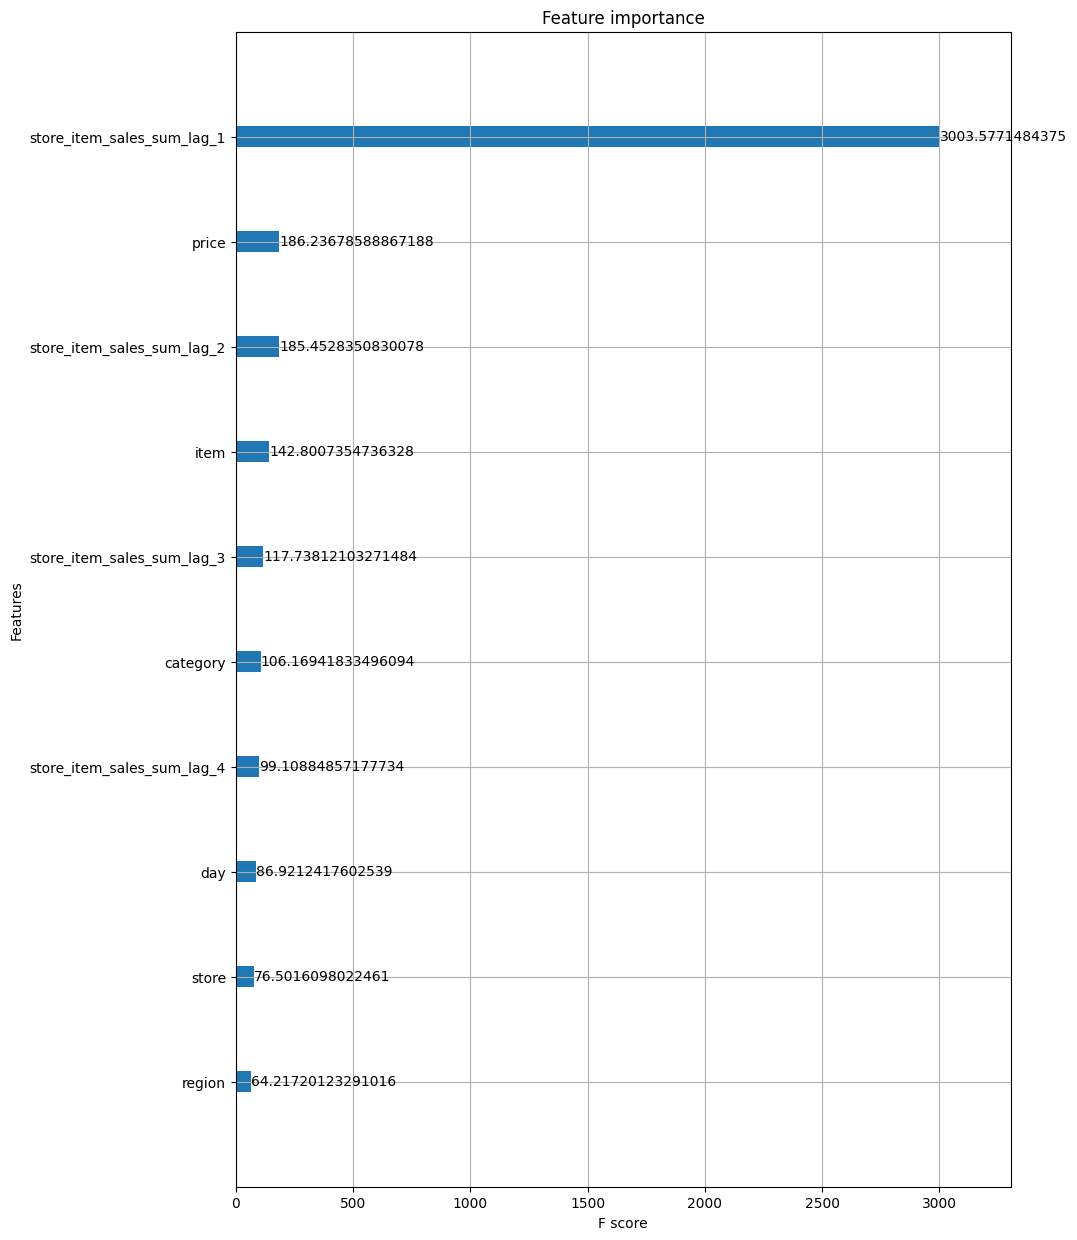

In [42]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

# Model Predict

In [43]:

Y_train_predict = model.predict(X_train).clip(0,30)
Y_valida_predict = model.predict(X_valida).clip(0,30)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 3_182
Validation RMSE: 2_937


# Model Evaluations

### Evaluación del Error

RMSE: 2.9367
MAE: 1.9463
R2-Score: 84.16%


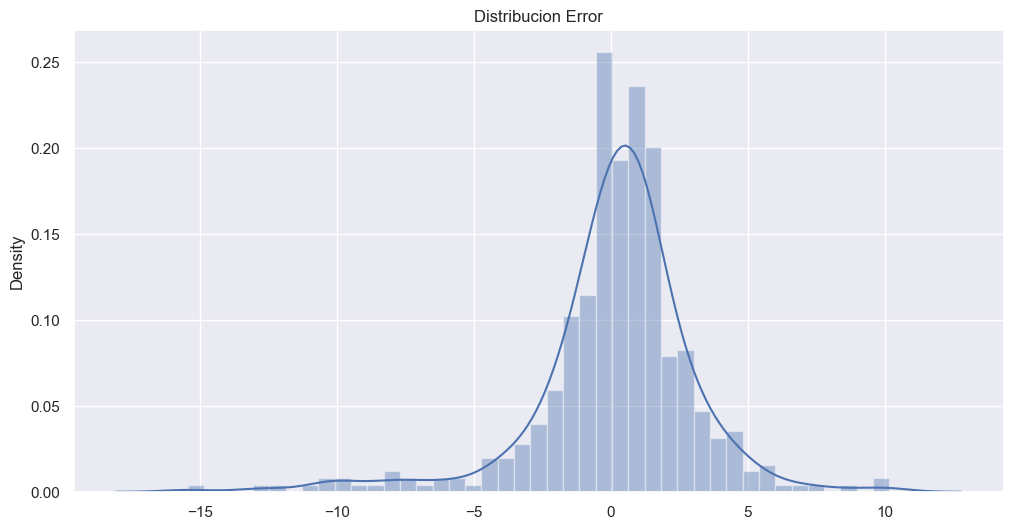

In [44]:
error = Y_valida_predict - Y_valida.values

mae = np.mean(np.abs(error))
mse = np.mean(error**2)
rmse = np.sqrt(np.mean(error**2))

print('RMSE:', round(rmse,4))
print('MAE:', round(mae,4))
print('R2-Score: {:.2%}'.format(r2_score(Y_valida, Y_valida_predict)))

sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(error).set_title('Distribucion Error')
plt.show()

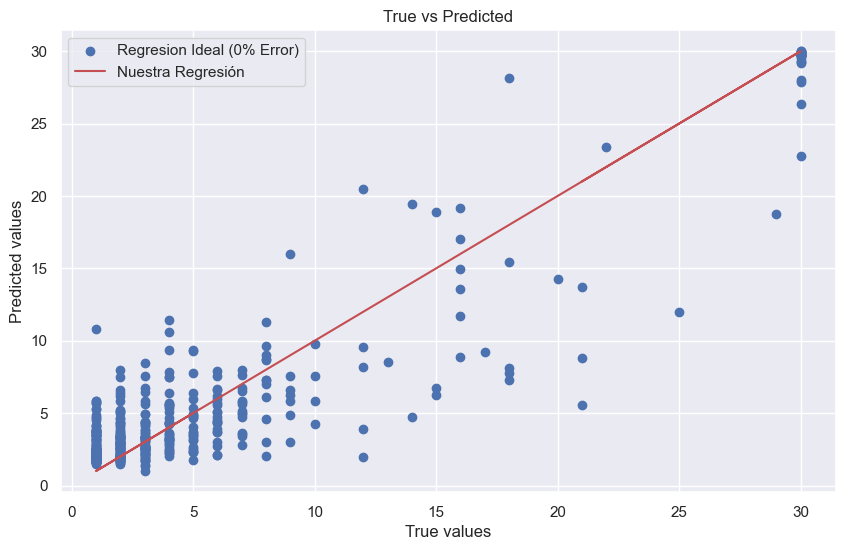

In [45]:
#Compara Prediccion vs dato real
plt.figure(figsize=[10,6])
plt.scatter(Y_valida, Y_valida_predict)
plt.plot(Y_valida, Y_valida,'r')
plt.title('True vs Predicted')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(['Regresion Ideal (0% Error)','Nuestra Regresión'])
plt.show()

### Intervalo de confianza del Error

In [46]:
confidence=95
z = (100-confidence)/2
print("Intervalo del error (confianza",confidence,"%):",round(np.percentile(error, 100-z),1),"/",round(np.percentile(error, z),1))

Intervalo del error (confianza 95 %): 5.0 / -8.1


### Predición en datos de validacion

In [47]:
# Agregar la predicción como una nueva columna al DataFrame X_valida
X_valida.reset_index(inplace = True)
X_valida.head(2)
X_valida['sales_predict'] = Y_valida_predict

In [48]:
X_valida.head()

,id,region,store,category,item,price,day,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4,sales_predict
0,12_11365,16,12,9,11365,995.680556,30,13.0,6.0,11.0,30.0,13.682614
1,12_11369,16,12,9,11369,1321.367605,30,21.0,30.0,30.0,30.0,22.764364
2,12_11370,16,12,9,11370,681.715341,30,30.0,30.0,30.0,30.0,29.976801
3,12_11373,16,12,9,11373,437.929115,30,30.0,30.0,30.0,30.0,30.000000
4,12_12231,16,12,49,12231,350.000000,30,2.0,1.0,4.0,1.0,2.549664


# Test Prediction

In [49]:
# Eliminar la columna 'sales' si está presente
if "sales" in X_test.columns:
    X_test.drop("sales", axis=1, inplace=True)

# Realizar la predicción
Y_test_predict = model.predict(X_test).clip(0,30)

# Agregar la predicción como una nueva columna al DataFrame X_test
X_test.reset_index(inplace = True)
X_test['sales'] = Y_test_predict
X_test.head(2)

,id,region,store,category,item,price,day,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4,sales
0,12_11365,16,12,9,11365,0.0,31,NaN,NaN,NaN,NaN,2.357872
1,12_11369,16,12,9,11369,0.0,31,NaN,NaN,NaN,NaN,2.357872


In [50]:
X_test.shape

(426, 12)